In [181]:
import pandas as pd
import gzip
import numpy as np
import matplotlib.pyplot as plt
import os

In [256]:
#Load the barcode reads from the filtered fastq files
barcodes = []
for fastq in os.listdir('Filtered/'):
    if fastq.endswith('.gz'):
        with gzip.open('Filtered/'+ fastq) as file:
            l = 0
            for line in file:
                l+=1
                if l==1:
                    barcodes.append(str(line)[3:28]+'-'+fastq.split('_')[2])
                elif l ==4:
                    l = 0
barcodes = np.array(barcodes)

In [258]:
#Initialize the dicts for storing barcode obervations
RT_bcd = {}

Ligation1_FW = {}
Ligation1_RV = {}

Ligation2_FW = {}
Ligation2_RV = {}

PCR_FW = {}
PCR_RV = {}

index_FW = {}
index_RV = {}

###Load barcode whitelist
for bc in pd.read_excel('data/plasmid_sequencing/Barcodes.xlsx', sheet_name= 'RT')['barcode'].values:
    RT_bcd[bc] = 0

for bc in pd.read_excel('data/plasmid_sequencing/Barcodes.xlsx', sheet_name= 'ligation')['barcode'].values:
    PCR_FW[bc] = 0
    Ligation1_FW[bc] = 0
    Ligation2_FW[bc] = 0

for bc in pd.read_excel('data/plasmid_sequencing/Barcodes.xlsx', sheet_name= 'ligation')['barcode_rev'].values:
    PCR_RV[bc] = 0
    Ligation1_RV[bc] = 0
    Ligation2_RV[bc] = 0

for bc in pd.read_excel('data/plasmid_sequencing/Barcodes.xlsx', sheet_name= 'Index')['FW'].values:
    index_FW[bc] = 0

In [259]:
#iterate over uniquite observed bacodes
for bc in np.unique(barcodes):
    
    #Check if all barcode parts are in the whitelist, if yes (fully correct barcode), count it
    if (bc[6:12] in np.array(list(RT_bcd.keys()))) & (bc[13:19] in np.array(list(Ligation2_FW.keys()))) & (bc[19:25] in np.array(list(Ligation1_FW.keys()))) & (bc[:6] in np.array(list(PCR_RV.keys()))) & (bc[-8:] in np.array(list(index_FW.keys()))):
        RT_bcd[bc[6:12]] +=1
        Ligation2_FW[bc[13:19]] +=1
        Ligation1_FW[bc[19:25]] +=1
        PCR_RV[bc[:6]] +=1
        index_FW[bc[-8:]] +=1


In [260]:
#Make a dataframe
barocoding_plate = pd.DataFrame([np.array(list(Ligation1_FW.values())),
                   np.array(list(Ligation2_FW.values())),
                   np.array(list(PCR_RV.values()))]).T
barocoding_plate.columns = ['Ligation_1', 'Ligation_2', 'PCR_3']

In [261]:
#Make a dataframe for index and RT barcodes
index_data = pd.Series(index_FW)
index_data = index_data[index_data>0]

RT_data = pd.Series(RT_bcd)

In [262]:
#Save all of the data
#writer = pd.ExcelWriter('Barcode_observations.xlsx', engine='xlsxwriter') # 'xlsxwriter' is a common engine
#index_data.to_excel(writer, sheet_name='Index_data')
#RT_data.to_excel(writer, sheet_name='RT_data')
#barocoding_plate['Ligation_1'].to_excel(writer, sheet_name='Ligation_1')
#barocoding_plate['Ligation_2'].to_excel(writer, sheet_name='Ligation_2')
#barocoding_plate['PCR_3'].to_excel(writer, sheet_name='PCR_3')
#writer.close()

Text(0, 0.5, 'Cumulative capsule fraction (%)')

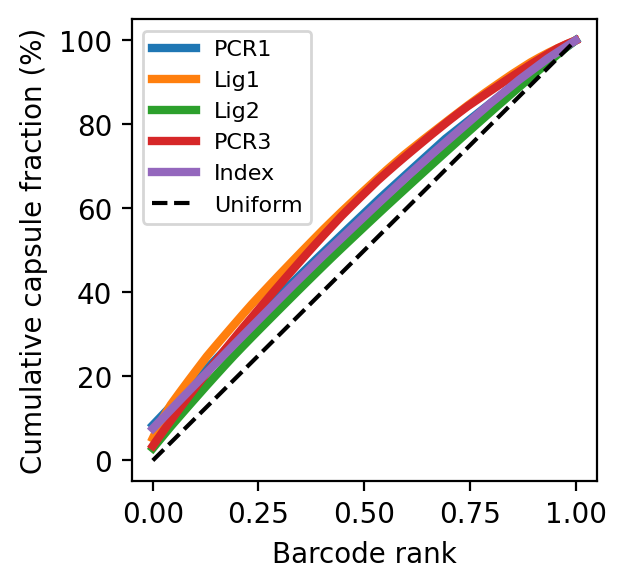

In [263]:
#Uniformity plot
fig, ax = plt.subplots(figsize = (3,3), dpi=200)
x = np.sort(RT_data.values)[::-1]
ax.plot(np.linspace(0, 1, 14), np.cumsum(x)/np.cumsum(x).max()*100, linewidth = 3, label = 'PCR1')
x = np.sort(barocoding_plate['Ligation_1'].values)[::-1]
ax.plot(np.linspace(0, 1, 48), np.cumsum(x)/np.cumsum(x).max()*100, linewidth = 3, label = 'Lig1')
x = np.sort(barocoding_plate['Ligation_2'].values)[::-1]
ax.plot(np.linspace(0, 1, 48), np.cumsum(x)/np.cumsum(x).max()*100, linewidth = 3, label = 'Lig2')
x = np.sort(barocoding_plate['PCR_3'].values)[::-1]
ax.plot(np.linspace(0, 1, 48), np.cumsum(x)/np.cumsum(x).max()*100, linewidth = 3, label = 'PCR3')
x = np.sort(index_data.values)[::-1]
ax.plot(np.linspace(0, 1, 16), np.cumsum(x)/np.cumsum(x).max()*100, linewidth = 3, label = 'Index')

ax.plot([0,1], [0,100], c='black', linestyle = '--', label = 'Uniform')
ax.legend(fontsize=8)
ax.set_xlabel('Barcode rank')
ax.set_ylabel('Cumulative capsule fraction (%)')


In [264]:
def perplexity(X):
    #Calculate the probability of observing a specific barcode
    p = X.values/X.values.sum()
    
    #Shannon Entropy
    SE = p * np.log2(p)
    
    #Get Perplexity
    H = 2**(-np.sum(SE))
    
    return H

In [265]:
Barcode_space = perplexity(RT_data)*perplexity(barocoding_plate['Ligation_1'])*perplexity(barocoding_plate['Ligation_2'])*perplexity(barocoding_plate['PCR_3'])*perplexity(index_data)
print(f'Shannon diversity: {Barcode_space}')

Shannon diversity: 21821294.208060674
